In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib


# Read Dataset

df = pd.read_csv(r"C:\Users\Manish\Desktop\Genetic dataset\train_genetic_disorders.csv")
df = df.dropna(how="all")

# Drop Irrelevant Columns from test dataset

drop_cols = [
    "Patient Id", "Family Name", "Institute Name", "Patient First Name",
    "Father's name", "Location of Institute", "Parental consent",
    "Test 1", "Test 2", "Test 3", "Test 4", "Test 5"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Drop Missing values in target columns

df = df.dropna(subset=["Genetic Disorder"])


# convert target variable into numerics 

label_enc = LabelEncoder()
df["Genetic Disorder Encoded"] = label_enc.fit_transform(df["Genetic Disorder"])
joblib.dump(label_enc, "label_encoder.pkl")  # saving the Genetic disorder new values

# Ensure target variable in 1D

y = df["Genetic Disorder Encoded"]  # 1D Series ,otherwisw it will throw error.
print("y shape:", y.shape)  # should be (n,)
print("y type:", type(y))   

# Remove only target columns from X

X = df.drop(["Genetic Disorder", "Genetic Disorder Encoded"], axis=1)

# Save training feature columns except target variables

feature_cols = X.columns.tolist()
joblib.dump(feature_cols, "training_features.pkl")


# Identify numeric & categorical columns

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing Pipelines

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# preprocessing is done


# Model used for prediction XGboost

num_classes = y.nunique()
model = XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    num_class=num_classes,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

# Full/Final  Pipeline 

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", model)
])


# Train the model 

pipeline.fit(X, y)
print("Training complete.")

# Save Pipeline/results for visualization 

joblib.dump(pipeline, "genetic_disorder_pipeline.pkl")
print("Pipeline saved as 'genetic_disorder_pipeline.pkl'.")

y shape: (18962,)
y type: <class 'pandas.core.series.Series'>
Training complete.
Pipeline saved as 'genetic_disorder_pipeline.pkl'.


In [29]:
import pandas as pd
import numpy as np
import joblib


# Load pipeline, label encoder, and training features

pipeline = joblib.load("genetic_disorder_pipeline.pkl")
label_enc = joblib.load("label_encoder.pkl")
feature_cols = joblib.load("training_features.pkl")


# Load test dataset

df_test = pd.read_csv(r"C:\Users\Man\Desktop\Genetic dataset\test_genetic_disorders.csv")
df_test = df_test.dropna(how="all")

# Drop irrelevant columns
drop_cols = [
    "Patient Id", "Family Name", "Institute Name", "Patient First Name",
    "Father's name", "Location of Institute", "Parental consent",
    "Test 1", "Test 2", "Test 3", "Test 4", "Test 5"
]
df_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns], errors="ignore")


# Align columns with training features

for col in feature_cols:
    if col not in df_test.columns:
        df_test[col] = np.nan

df_test = df_test[feature_cols]


# Predict probabilities

probs = pipeline.predict_proba(df_test)

# Top 2 indices per row
top2_idx = np.argsort(probs, axis=1)[:, -2:]
top2_probs = np.take_along_axis(probs, top2_idx, axis=1)

# Correctly convert indices to labels row-wise
top2_labels = np.array([label_enc.inverse_transform(row) for row in top2_idx])

# Assign Top 1 and Top 2
pred_top1 = top2_labels[:, 1]
prob_top1 = top2_probs[:, 1]
pred_top2 = top2_labels[:, 0]
prob_top2 = top2_probs[:, 0]

# Create summary

summary = [f"{p1} ({pr1:.2f}), 2nd: {p2} ({pr2:.2f})"
           for p1, pr1, p2, pr2 in zip(pred_top1, prob_top1, pred_top2, prob_top2)]

# Convert probabilities to DataFrame
class_names = label_enc.classes_
probs_df = pd.DataFrame(probs, columns=[f"Prob_{cls}" for cls in class_names])

# Combine with test data
df_results = df_test.copy()
df_results["Prediction Top1"] = pred_top1
df_results["Probability Top1"] = prob_top1
df_results["Prediction Top2"] = pred_top2
df_results["Probability Top2"] = prob_top2
df_results["Prediction Summary"] = summary
df_results = pd.concat([df_results, probs_df], axis=1)

# Save results
df_results.to_csv("test_predictions_top2_summary_fixed.csv", index=False)
print("Predictions saved to 'test_predictions_top2_summary_fixed.csv'.")


Predictions saved to 'test_predictions_top2_summary_fixed.csv'.


In [31]:
df_results = pd.read_csv("test_predictions_top2_summary_fixed.csv")
print(df_results.head())


   Patient Age Genes in mother's side Inherited from father Maternal gene  \
0          6.0                     No                   Yes            No   
1         10.0                    Yes                    No           NaN   
2          5.0                     No                   NaN            No   
3         13.0                     No                   Yes           Yes   
4          5.0                     No                   NaN           NaN   

  Paternal gene  Blood cell count (mcL)  Mother's age  Father's age    Status  \
0            No                4.981655          38.0          61.0     Alive   
1           Yes                5.118890          33.0          53.0     Alive   
2            No                4.876204          48.0          60.0  Deceased   
3            No                4.687767          25.0          55.0     Alive   
4           Yes                5.152362          41.0          38.0  Deceased   

  Respiratory Rate (breaths/min)  ... Symptom 5 Di

C:\Users\Manish\AppData\Local\Temp\ipykernel_22624\1148709310.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


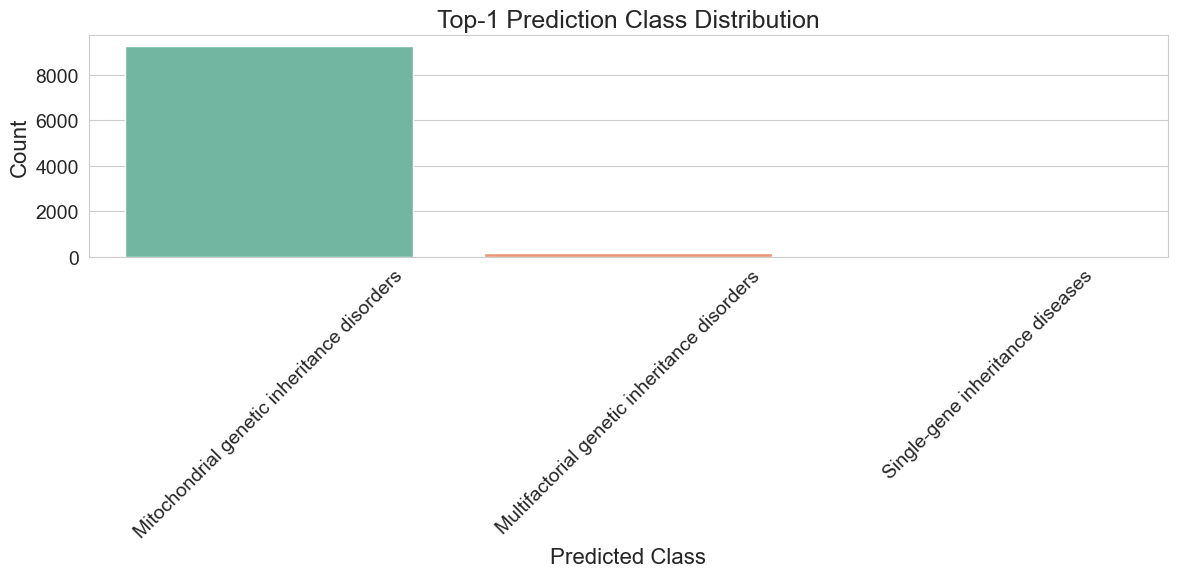

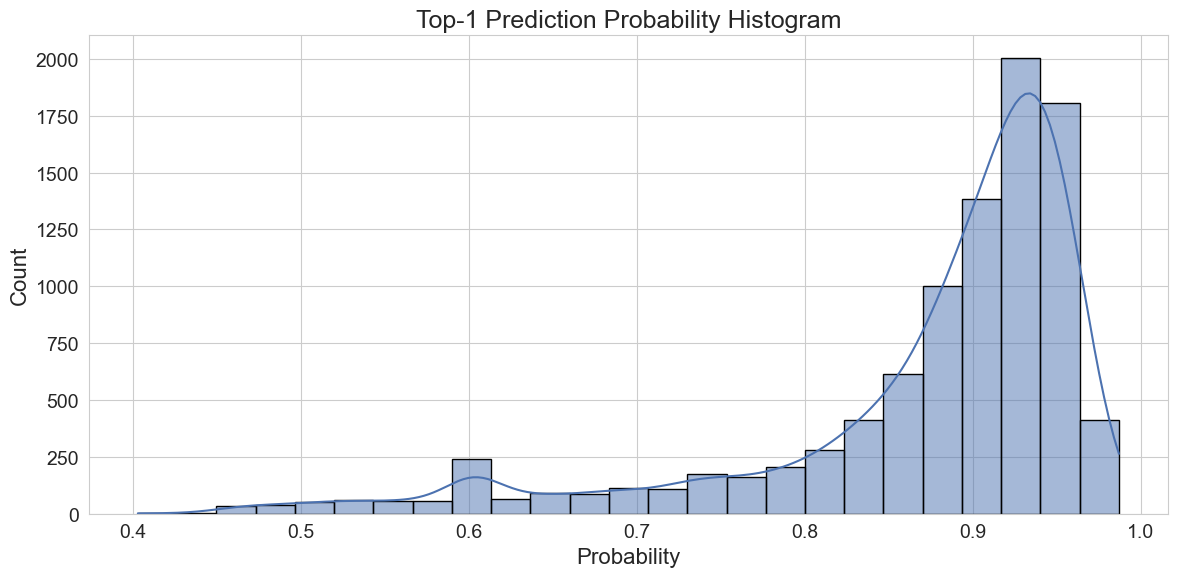

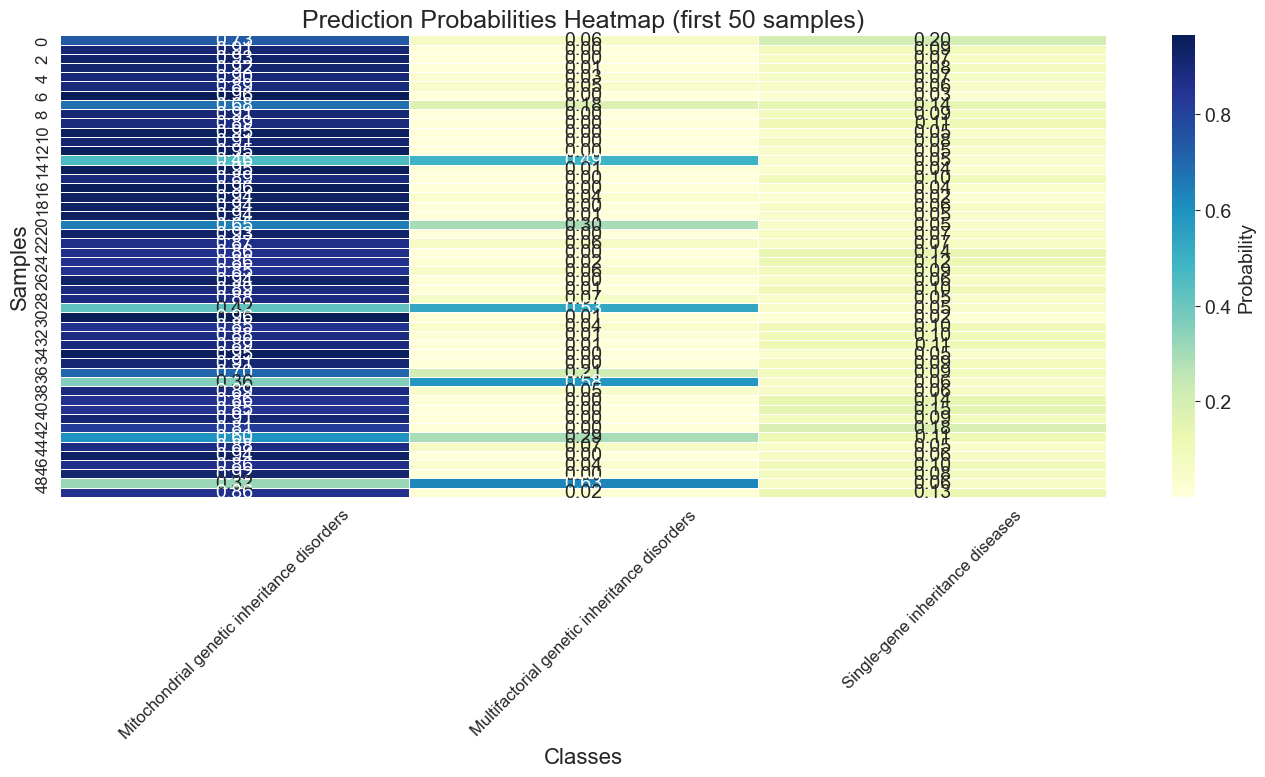

                               Prediction Top1  Probability Top1  \
0  Mitochondrial genetic inheritance disorders          0.731461   
1  Mitochondrial genetic inheritance disorders          0.910098   
2  Mitochondrial genetic inheritance disorders          0.928314   
3  Mitochondrial genetic inheritance disorders          0.916868   
4  Mitochondrial genetic inheritance disorders          0.901860   

                    Prediction Top2  Probability Top2  \
0  Single-gene inheritance diseases          0.204565   
1  Single-gene inheritance diseases          0.087831   
2  Single-gene inheritance diseases          0.071130   
3  Single-gene inheritance diseases          0.077135   
4  Single-gene inheritance diseases          0.067714   

                                  Prediction Summary  
0  Mitochondrial genetic inheritance disorders (0...  
1  Mitochondrial genetic inheritance disorders (0...  
2  Mitochondrial genetic inheritance disorders (0...  
3  Mitochondrial genetic inh

In [45]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


# Ensure plots show in Jupyter

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})  # increase font size globally


# Load model, label encoder, and feature list

pipeline = joblib.load("genetic_disorder_pipeline.pkl")
label_enc = joblib.load("label_encoder.pkl")
feature_cols = joblib.load("training_features.pkl")


# Load test dataset

df_test = pd.read_csv(r"C:\Users\Manish\Desktop\Genetic dataset\test_genetic_disorders.csv")

# Drop irrelevant columns
drop_cols = [
    "Patient Id", "Family Name", "Institute Name", "Patient First Name",
    "Father's name", "Location of Institute", "Parental consent",
    "Test 1", "Test 2", "Test 3", "Test 4", "Test 5"
]
df_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns], errors="ignore")

# Align columns with training features
for col in feature_cols:
    if col not in df_test.columns:
        df_test[col] = np.nan
df_test = df_test[feature_cols]


# Predict probabilities

probs = pipeline.predict_proba(df_test)
top2_idx = np.argsort(probs, axis=1)[:, -2:]
top2_probs = np.take_along_axis(probs, top2_idx, axis=1)
top2_labels = np.array([label_enc.inverse_transform(row) for row in top2_idx])

pred_top1 = top2_labels[:, 1]
prob_top1 = top2_probs[:, 1]
pred_top2 = top2_labels[:, 0]
prob_top2 = top2_probs[:, 0]

summary = [f"{p1} ({pr1:.2f}), 2nd: {p2} ({pr2:.2f})"
           for p1, pr1, p2, pr2 in zip(pred_top1, prob_top1, pred_top2, prob_top2)]

df_results = df_test.copy()
df_results["Prediction Top1"] = pred_top1
df_results["Probability Top1"] = prob_top1
df_results["Prediction Top2"] = pred_top2
df_results["Probability Top2"] = prob_top2
df_results["Prediction Summary"] = summary


# Top-1 Class Distribution

plt.figure(figsize=(12,6))
sns.countplot(
    x="Prediction Top1",
    data=df_results,
    order=np.sort(df_results["Prediction Top1"].unique()),
    palette="Set2"
)
plt.title("Top-1 Prediction Class Distribution", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.tight_layout()
plt.show()


# Top-1 Probability Histogram

plt.figure(figsize=(12,6))
sns.histplot(df_results["Probability Top1"], bins=25, kde=True, color="#4c72b0", edgecolor='black')
plt.title("Top-1 Prediction Probability Histogram", fontsize=18)
plt.xlabel("Probability", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


# Top-2 Coverage Pie Chart (if true labels exist)

if "Genetic Disorder" in df_results.columns:
    top2_match = (df_results["Prediction Top1"] == df_results["Genetic Disorder"]) | \
                 (df_results["Prediction Top2"] == df_results["Genetic Disorder"])
    coverage_counts = [top2_match.sum(), len(top2_match)-top2_match.sum()]
    plt.figure(figsize=(6,6))
    plt.pie(
        coverage_counts,
        labels=["Covered in Top-2", "Not Covered"],
        autopct="%1.1f%%",
        colors=["#66c2a5","#fc8d62"],
        textprops={'fontsize': 14}
    )
    plt.title("Top-2 Coverage Pie Chart", fontsize=18)
    plt.show()


# 4. Probability Heatmap for All Classes (first 50 samples)

class_names = label_enc.classes_
probs_df = pd.DataFrame(probs, columns=class_names)

plt.figure(figsize=(14,8))
sns.heatmap(
    probs_df.iloc[:50],   # first 50 samples
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Probability'}
)
plt.title("Prediction Probabilities Heatmap (first 50 samples)", fontsize=18)
plt.xlabel("Classes", fontsize=16)
plt.ylabel("Samples", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Display Top 5 Predictions
print(df_results[["Prediction Top1","Probability Top1","Prediction Top2","Probability Top2","Prediction Summary"]].head())


Low-confidence predictions (<0.6 probability): 333 samples


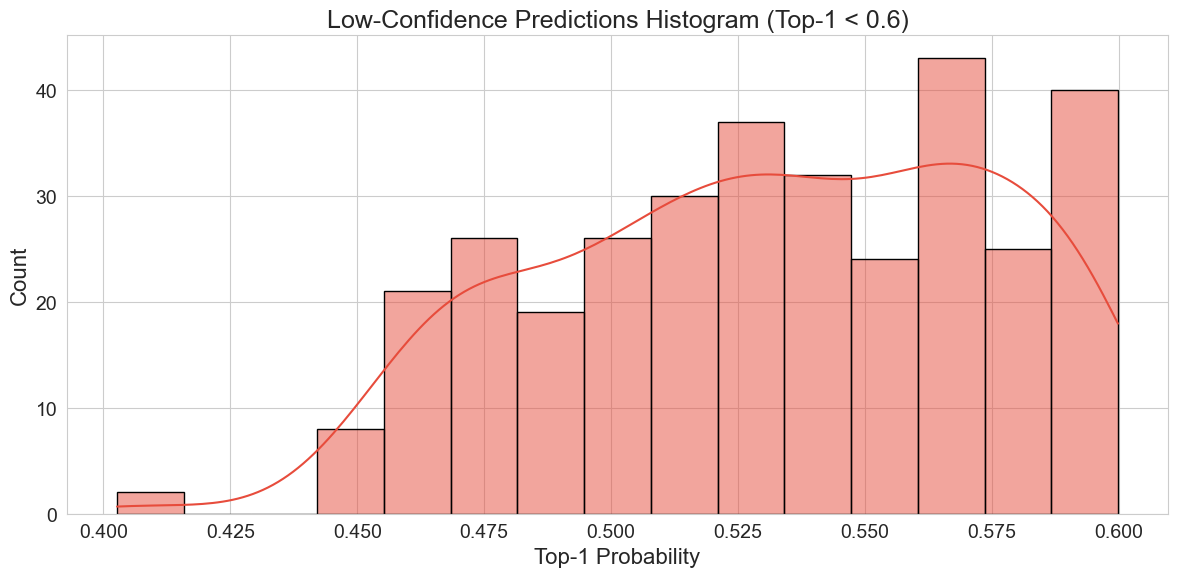

Borderline predictions (Top-1 vs Top-2 difference <0.1): 114 samples


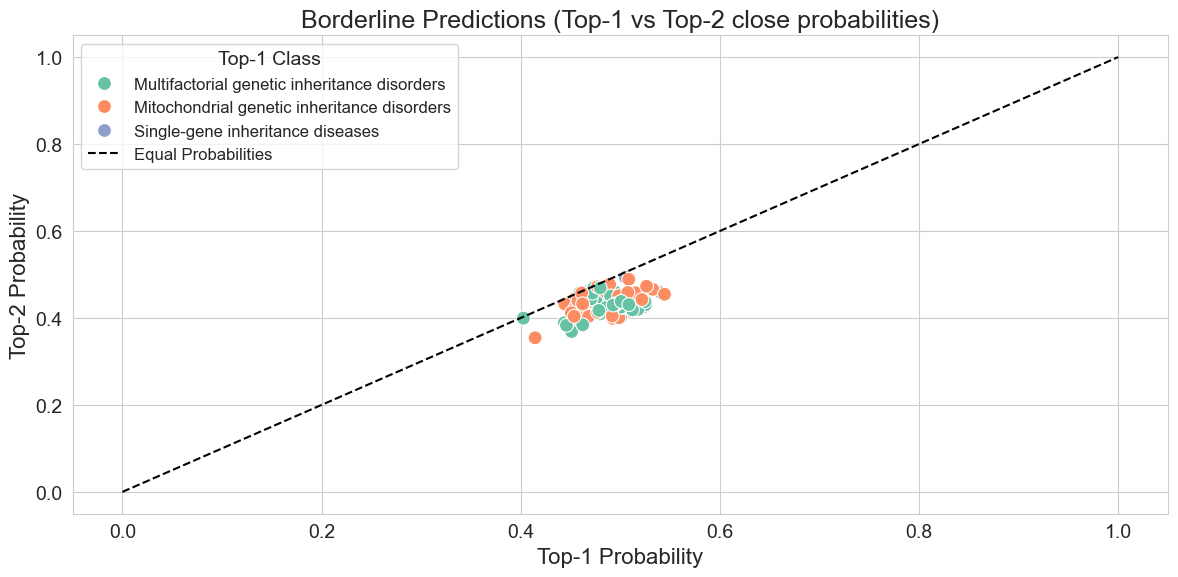

C:\Users\Manish\AppData\Local\Temp\ipykernel_22624\2827356799.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


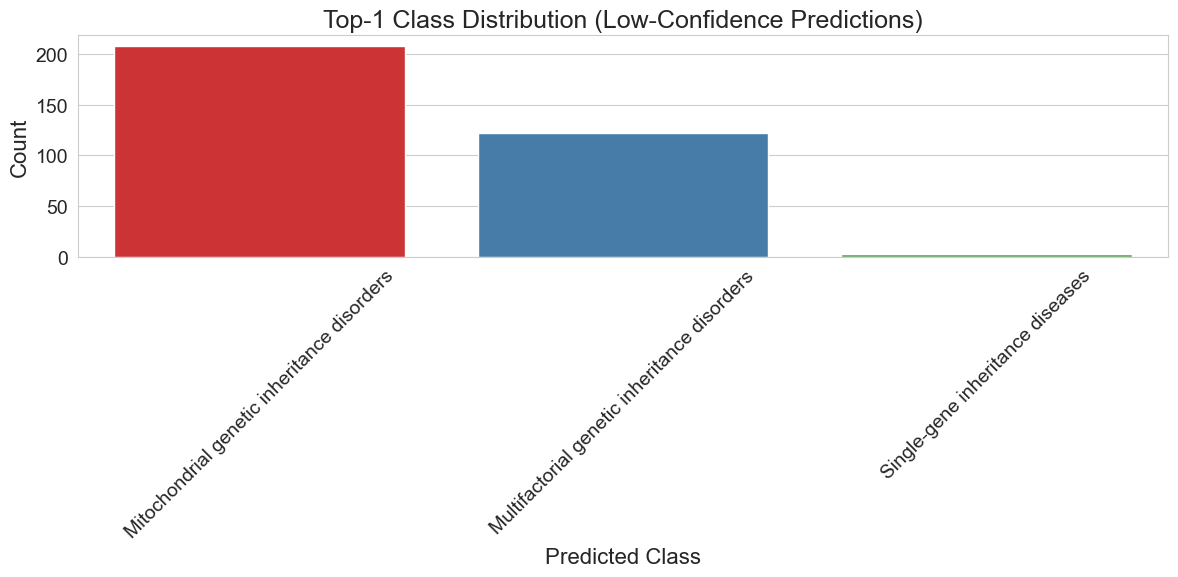

In [47]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


# Ensure plots show in Jupyter

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})


# Load model, label encoder, and feature list

pipeline = joblib.load("genetic_disorder_pipeline.pkl")
label_enc = joblib.load("label_encoder.pkl")
feature_cols = joblib.load("training_features.pkl")


# Load test dataset

df_test = pd.read_csv(r"C:\Users\Manish\Desktop\Genetic dataset\test_genetic_disorders.csv")

# Drop irrelevant columns

drop_cols = [
    "Patient Id", "Family Name", "Institute Name", "Patient First Name",
    "Father's name", "Location of Institute", "Parental consent",
    "Test 1", "Test 2", "Test 3", "Test 4", "Test 5"
]
df_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns], errors="ignore")

# Align columns with training features

for col in feature_cols:
    if col not in df_test.columns:
        df_test[col] = np.nan
df_test = df_test[feature_cols]


# Predict probabilities

probs = pipeline.predict_proba(df_test)
top2_idx = np.argsort(probs, axis=1)[:, -2:]
top2_probs = np.take_along_axis(probs, top2_idx, axis=1)
top2_labels = np.array([label_enc.inverse_transform(row) for row in top2_idx])

pred_top1 = top2_labels[:, 1]
prob_top1 = top2_probs[:, 1]
pred_top2 = top2_labels[:, 0]
prob_top2 = top2_probs[:, 0]

# Create summary
summary = [f"{p1} ({pr1:.2f}), 2nd: {p2} ({pr2:.2f})"
           for p1, pr1, p2, pr2 in zip(pred_top1, prob_top1, pred_top2, prob_top2)]

df_results = df_test.copy()
df_results["Prediction Top1"] = pred_top1
df_results["Probability Top1"] = prob_top1
df_results["Prediction Top2"] = pred_top2
df_results["Probability Top2"] = prob_top2
df_results["Prediction Summary"] = summary


# Highlight Low-Confidence Predictions (Top-1 < 0.6)

low_confidence = df_results[df_results["Probability Top1"] < 0.6]
print(f"Low-confidence predictions (<0.6 probability): {len(low_confidence)} samples")

plt.figure(figsize=(12,6))
sns.histplot(low_confidence["Probability Top1"], bins=15, kde=True, color="#e74c3c", edgecolor='black')
plt.title("Low-Confidence Predictions Histogram (Top-1 < 0.6)", fontsize=18)
plt.xlabel("Top-1 Probability", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.tight_layout()
plt.show()

# Highlight Borderline Predictions (Top-1 vs Top-2 difference < 0.1)

borderline = df_results[np.abs(df_results["Probability Top1"] - df_results["Probability Top2"]) < 0.1]
print(f"Borderline predictions (Top-1 vs Top-2 difference <0.1): {len(borderline)} samples")

plt.figure(figsize=(12,6))
sns.scatterplot(
    x="Probability Top1",
    y="Probability Top2",
    hue="Prediction Top1",
    data=borderline,
    palette="Set2",
    s=100
)
plt.plot([0,1],[0,1], 'k--', label="Equal Probabilities")
plt.title("Borderline Predictions (Top-1 vs Top-2 close probabilities)", fontsize=18)
plt.xlabel("Top-1 Probability", fontsize=16)
plt.ylabel("Top-2 Probability", fontsize=16)
plt.legend(fontsize=12, title="Top-1 Class")
plt.tight_layout()
plt.show()


# Top-1 Class Distribution for Low-Confidence Samples

plt.figure(figsize=(12,6))
sns.countplot(
    x="Prediction Top1",
    data=low_confidence,
    order=np.sort(low_confidence["Prediction Top1"].unique()),
    palette="Set1"
)
plt.title("Top-1 Class Distribution (Low-Confidence Predictions)", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.tight_layout()
plt.show()
